In [2]:
import torch
import torch.nn as nn

In [3]:
import numpy as np
import os

In [4]:
import matplotlib
from pylab import *
import skimage as sk
import skimage.io as io
from skimage.color import rgb2gray
from scipy.signal import convolve2d
import scipy.signal as signal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
fox = io.imread("/kaggle/input/fox-image/fox.jpg")

In [23]:
class PosEncoding(nn.Module):
    def __init__(self, L):
        super(PosEncoding, self).__init__()
        self.L = L
        self.d_model = 4 * L + 2
        
    def forward(self, x):
        batch_size = x.shape[0]
        result = torch.zeros(batch_size, self.d_model)
        result[:, 0] = x[:, 0]
        result[:, 1] = x[:, 1]
        positions = torch.arange(0, self.L).unsqueeze(0).expand(batch_size, -1).float()
        result[:, 2:2*self.L + 2:2] = torch.sin(2 ** positions * np.pi * x[:, 0].unsqueeze(1))
        result[:, 3:2*self.L + 3:2] = torch.cos(2 ** positions * np.pi * x[:, 0].unsqueeze(1))
        result[:, 2*self.L+2:4*self.L + 2:2] = torch.sin(2 ** positions * np.pi * x[:, 1].unsqueeze(1))
        result[:, 2*self.L+3:4*self.L + 3:2] = torch.cos(2 ** positions * np.pi * x[:, 1].unsqueeze(1))
        return torch.tensor(result, dtype=torch.float32)

In [24]:
class Nerf2D(nn.Module):
    def __init__(self):
        super(Nerf2D, self).__init__()
        L = 10
        d_model = 4 * L + 2
        self.positional_encoding = PosEncoding(L)
        self.nerf = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )  # from (batch_size, d_model) to (batch_size, 3)

    def forward(self, x):
        """
        :param x: it should be a tensor with shape (batch_size, 2(input_dim)))
        :return: 
        """
        x = self.positional_encoding(x)
        x = self.nerf(x)
        return x

In [49]:
class NerfDataset(Dataset):
    def __init__(self, image):
        super(NerfDataset, self).__init__()
        self.image = image
        self.width = self.image.shape[1]
        self.height = self.image.shape[0]
        
    def __len__(self):
        return 10
    
    def __getitem__(self,index,batch_size=200000):
        # randomly choose a point within the image
        x = np.random.randint(0, self.width, size=(batch_size, 1))
        y = np.random.randint(0, self.height, size=(batch_size, 1))
        points = np.concatenate([x, y], axis=1)
        rgb_values = np.array([self.image[point[1], point[0]] for point in points])
        points = points.astype(np.float32)
        rgb_values = rgb_values.astype(np.float32)
        points[:, 0] = points[:, 0] / self.width
        points[:, 1] = points[:, 1] / self.height
        rgb_values = rgb_values / 255
        return torch.tensor(points), torch.tensor(rgb_values)

dataset = NerfDataset(fox)

dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

In [64]:
def sample(image,batch_size=10000):
        width = image.shape[1]
        height = image.shape[0]
        # randomly choose a point within the image
        x = np.random.randint(0, width, size=(batch_size, 1))
        y = np.random.randint(0, height, size=(batch_size, 1))
        points = np.concatenate([x, y], axis=1)
        rgb_values = np.array([image[point[1], point[0]] for point in points])
        points = points.astype(np.float32)
        rgb_values = rgb_values.astype(np.float32)
        points[:, 0] = points[:, 0] / width
        points[:, 1] = points[:, 1] / height
        rgb_values = rgb_values / 255
        return torch.tensor(points), torch.tensor(rgb_values)

In [45]:
coord = sample(fox,batch_size=10000)[0]
coord.shape

torch.Size([10000, 2])

In [65]:
dataset = sample(fox,batch_size=10000)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

In [60]:
def PSNR(value):
  return 10 *  np.log(1/value)

In [68]:
model = Nerf2D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fox_tensor = torch.tensor(fox).to(torch.float32)
num_epochs = 1000
import time 
start_time = time.time()
running_losses = []
for epoch in range(num_epochs):
        coord, color = sample(fox, batch_size=10000)
        coords_tensor = torch.tensor(coord)
        colors_tensor = torch.tensor(color)
        optimizer.zero_grad()
        outputs = model(coords_tensor)
        loss = criterion(outputs, colors_tensor)
        loss.backward() 
        optimizer.step()
        running_losses.append(loss.item())

        if epoch % 100 == 0:
            print('[%d] loss: %.3f' % (epoch + 1, sum(running_losses) / len(running_losses)))
            print('psnr: %.3f' % (PSNR(sum(running_losses) / len(running_losses))) )
            end_time = time.time()
            epoch_time = end_time - start_time
            print('%f' % epoch_time)
            start_time = time.time()
            running_losses = []

print('Finished Training') 

/tmp/ipykernel_47/3426545419.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords_tensor = torch.tensor(coord)
/tmp/ipykernel_47/3426545419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_tensor = torch.tensor(color)
/tmp/ipykernel_47/3075110642.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(result, dtype=torch.float32)


[1] loss: 0.104
psnr: 22.623
0.073047
[101] loss: 0.039
psnr: 32.458
7.660849
[201] loss: 0.009
psnr: 47.431
7.009076
[301] loss: 0.005
psnr: 52.685
7.075870
[401] loss: 0.004
psnr: 54.982
7.158761
[501] loss: 0.004
psnr: 56.319
7.036587
[601] loss: 0.003
psnr: 57.260
7.296832
[701] loss: 0.003
psnr: 57.937
7.034960
[801] loss: 0.003
psnr: 58.341
7.045451
[901] loss: 0.003
psnr: 58.845
7.125402
Finished Training


/tmp/ipykernel_47/3075110642.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(result, dtype=torch.float32)


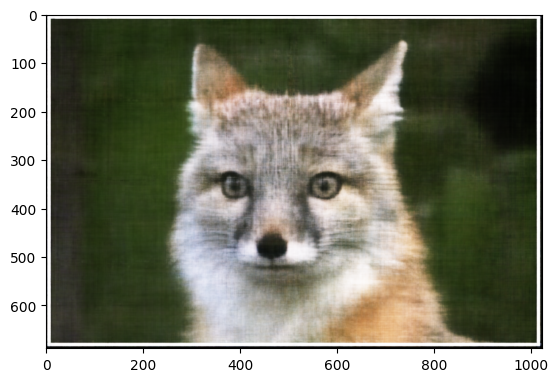

In [86]:
with torch.no_grad():
    model.eval()
    y, x = np.meshgrid(np.linspace(0, 1, 1024), np.linspace(0, 1, 689))
    coords = np.dstack((y, x))
    flattened_coords = coords.reshape(-1, 2)
    coords_tensor = torch.tensor(flattened_coords, dtype=torch.float32)
    outputs = model(coords_tensor)
    predicted_colors = outputs.view(689, 1024,3) 
plt.imshow(predicted_colors.detach().cpu().numpy())

In [78]:
predicted_colors

[tensor([0.0027, 0.0029, 0.0019]),
 tensor([0.0037, 0.0039, 0.0026]),
 tensor([0.0049, 0.0051, 0.0036]),
 tensor([0.0068, 0.0071, 0.0056]),
 tensor([0.0180, 0.0198, 0.0204]),
 tensor([0.0544, 0.0580, 0.0680]),
 tensor([0.0491, 0.0532, 0.0599]),
 tensor([0.0413, 0.0463, 0.0494]),
 tensor([0.0562, 0.0640, 0.0674]),
 tensor([0.1009, 0.1132, 0.1195]),
 tensor([0.1255, 0.1393, 0.1408]),
 tensor([0.1209, 0.1348, 0.1286]),
 tensor([0.1176, 0.1340, 0.1207]),
 tensor([0.0546, 0.0670, 0.0555]),
 tensor([0.0225, 0.0290, 0.0234]),
 tensor([0.0161, 0.0200, 0.0161]),
 tensor([0.0172, 0.0210, 0.0170]),
 tensor([0.0210, 0.0257, 0.0204]),
 tensor([0.0259, 0.0322, 0.0256]),
 tensor([0.0279, 0.0351, 0.0282]),
 tensor([0.0320, 0.0406, 0.0318]),
 tensor([0.0338, 0.0433, 0.0340]),
 tensor([0.0321, 0.0408, 0.0331]),
 tensor([0.0325, 0.0403, 0.0338]),
 tensor([0.0327, 0.0397, 0.0334]),
 tensor([0.0313, 0.0375, 0.0308]),
 tensor([0.0306, 0.0360, 0.0290]),
 tensor([0.0292, 0.0342, 0.0271]),
 tensor([0.0294, 0.0

In [71]:
y, x = np.meshgrid(np.linspace(0, 1, 689), np.linspace(0, 1, 1024))
coords = np.dstack((y, x)).transpose(1, 0, 2)
flattened_coords = coords.reshape(-1, 2)
flattened_coords.shape

(705536, 2)

In [ ]:
loss_function = MSELoss()
model = Nerf2D().to(device)
optimizer = Adam(model.parameters(), lr=1e-2)

In [5]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(42, 256)
    self.activation = torch.nn.ReLU()
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 3)
    self.sigmoid =  nn.Sigmoid()


  def forward(self, x):
    x = self.positionEncoder(x, 10)
    x = self.linear1(x)
    x = self.activation(x)
    x = self.linear2(x)
    x = self.activation(x)
    x = self.linear2(x)
    x = self.activation(x)
    x = self.linear3(x)
    x = self.sigmoid(x)
    return x

  def positionEncoder(self, positions, L):
    num_samples, channel = positions.shape

# Convert positions to a PyTorch tensor
    positions_unsqueezed = torch.tensor(positions, dtype=torch.float32).unsqueeze(-1)

# Expand frequencies to match the shape of positions
    frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

# Perform element-wise multiplication
    sin_values = torch.sin(2.0 ** frequencies * positions_unsqueezed * np.pi)
    cos_values = torch.cos(2.0 ** frequencies * positions_unsqueezed * np.pi)
    tensor1 = sin_values.view(-1)
    tensor2 = cos_values.view(-1)
    merged_tensor = []
    for i in range(0, len(tensor1),2):
        merged_tensor.append(tensor1[i])
        merged_tensor.append(tensor1[i+1])
        merged_tensor.append(tensor2[i])
        merged_tensor.append(tensor2[i+1])
    merged_tensor = torch.tensor(merged_tensor)
    encoding_vector = merged_tensor.view(num_samples, -1)
    encoding_vector = torch.cat((torch.tensor(positions,dtype=torch.float32), encoding_vector), dim=-1)
    return encoding_vector 

In [84]:
def positionEncoder(positions, L):
    num_samples, channel = positions.shape

# Convert positions to a PyTorch tensor
    positions = torch.tensor(positions, dtype=torch.float32).unsqueeze(-1)

# Expand frequencies to match the shape of positions
    frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

# Perform element-wise multiplication
    sin_values = torch.sin(2.0 ** frequencies * positions * np.pi)
    cos_values = torch.cos(2.0 ** frequencies * positions * np.pi)

    encoding_vector = torch.cat((sin_values, cos_values), dim=-1).view(2, -1)
    encoding_vector = torch.cat((positions.view(2, -1), encoding_vector), dim=-1)
    return encoding_vector
    

In [14]:
L = 10
positions = np.array([[1, 2], [3, 4]])
num_samples, channel = positions.shape
# positions = positions.view(num_sample, channel)
frequencies = torch.arange(L, dtype=torch.float32)
# positions = positions.view(x, y, channel)
frequencies * positions

ValueError: operands could not be broadcast together with shapes (10,) (2,2) 

In [83]:
L = 2
positions = np.array([[1, 2], [3, 4]])
num_samples, channel = positions.shape

# Convert positions to a PyTorch tensor
positions = torch.tensor(positions, dtype=torch.float32).unsqueeze(-1)

# Expand frequencies to match the shape of positions
frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

# Perform element-wise multiplication
sin_values = torch.sin(2.0 ** frequencies * positions * np.pi)
cos_values = torch.cos(2.0 ** frequencies * positions * np.pi)

# print("sin")
# print(sin_values.shape)
# print("cos")
# print(cos_values)

encoding_vector = torch.cat((sin_values, cos_values), dim=-1).view(2, -1)
encoding_vector = torch.cat((positions.view(2, -1), encoding_vector), dim=-1)

# encoding_vector = encoding_vector.view(encoding_vector.shape[0], encoding_vector.shape[1] * encoding_vector.shape[2])

# Print the result
print(encoding_vector)

tensor([[ 1.0000e+00,  2.0000e+00, -8.7423e-08,  1.7485e-07, -1.0000e+00,
          1.0000e+00,  1.7485e-07,  3.4969e-07,  1.0000e+00,  1.0000e+00],
        [ 3.0000e+00,  4.0000e+00, -2.3850e-08,  4.7700e-08, -1.0000e+00,
          1.0000e+00,  3.4969e-07,  6.9938e-07,  1.0000e+00,  1.0000e+00]])


In [6]:
test_points = np.array([[1, 2], [3, 4]])
test_pe = positionEncoder(test_points, 2)
test_expected = np.array([[1, 2, np.sin(1 * np.pi * 1), np.sin(1 * np.pi * 2), np.cos(1 * np.pi * 1), np.cos(1 * np.pi * 2), np.sin(2 * np.pi * 1), np.sin(2 * np.pi * 2), np.cos(2 * np.pi * 1), np.cos(2 * np.pi * 2)], 
                            [3, 4, np.sin(1 * np.pi * 3), np.sin(1 * np.pi * 4), np.cos(1 * np.pi * 3), np.cos(1 * np.pi * 4), np.sin(2 * np.pi * 3), np.sin(2 * np.pi * 4), np.cos(2 * np.pi * 3), np.cos(2 * np.pi * 4)]]
                        )
np.isclose(np.array(test_pe), test_expected, atol= 1e-6)
# print(np.array(test_pe))
# print(test_expected)

NameError: name 'positionEncoder' is not defined

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
class Dataloader(Dataset):
  def __init__(self, folder_path):
    self.image_list = []
    for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
        image = Image.open(file_path)
        self.image_list.append(image)

  def getTrainingSet():
    return

  def getTestingSet():
    return

  def __len__(self) -> int:
    return len(self.image_list)

In [22]:
class PosEncoding(nn.Module):
    def __init__(self, L):
        super(PosEncoding, self).__init__()
        self.L = L
        self.d_model = 4 * L + 2
        
    def forward(self, x):
        batch_size = x.shape[0]
        result = torch.zeros(batch_size, self.d_model)
        result[:, 0] = x[:, 0]
        result[:, 1] = x[:, 1]
        positions = torch.arange(0, self.L).unsqueeze(0).expand(batch_size, -1).float()
        result[:, 2:2*self.L + 2:2] = torch.sin(2 ** positions * np.pi * x[:, 0].unsqueeze(1))
        result[:, 3:2*self.L + 3:2] = torch.cos(2 ** positions * np.pi * x[:, 0].unsqueeze(1))
        result[:, 2*self.L+2:4*self.L + 2:2] = torch.sin(2 ** positions * np.pi * x[:, 1].unsqueeze(1))
        result[:, 2*self.L+3:4*self.L + 3:2] = torch.cos(2 ** positions * np.pi * x[:, 1].unsqueeze(1))
        return torch.tensor(result, dtype=torch.float32)

In [ ]:
positions = sampleImage(fox, 100)[0]

In [ ]:
positions = sample
encoded = positionEncoder(np.array(sample), 10)
print(encoded)

In [107]:
import random
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, TensorDataset

In [315]:
def sampleImage(img, N):
  assert len(img.shape) == 3
  assert len(img.shape) == 3
  if len(img) * len(img[0]) <= N:
    return img
  image_width, image_height = img.shape[1], img.shape[0]
  random_x = np.random.randint(0, image_width, size=N)
  random_y = np.random.randint(0, image_height, size=N)
  coords = np.column_stack((random_x, random_y))
  colors = np.array([img[y][x] for x, y in coords])
  coords_normalized = np.array(coords / np.array([image_width, image_height]))
  colors_normalized = np.array(colors / 255.0)
  assert len(coords_normalized) == len(colors_normalized)
  return [torch.tensor(coords_normalized , dtype=torch.float32), torch.tensor(colors_normalized , dtype=torch.float32)]

In [113]:
img = fox
N = 10000
sample = sampleImage(img, N)[1]
sample.shape

torch.Size([10000, 3])

In [ ]:
sample.shape

In [ ]:
is_between_0_and_1 = (sample >= 0) & (sample <= 1)

# Check if all values satisfy the condition
all_between_0_and_1 = is_between_0_and_1.all()

print(all_between_0_and_1)

In [316]:
def PSNR(value):
  return 10 *  np.log(1/value)

Training

In [7]:
import matplotlib
from pylab import *
import skimage as sk
import skimage.io as io
from skimage.color import rgb2gray
from scipy.signal import convolve2d
import scipy.signal as signal

In [105]:
model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
fox_tensor = torch.tensor(fox).to(torch.float32) 

In [ ]:
!pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [108]:
import tqdm
from torch.utils.tensorboard import SummaryWriter

# tb_writer = SummaryWriter(log_dir=save_dir)

# This moves the network to GPU.
net = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

num_epochs = 2
for epoch in range(num_epochs):
    train_loader_coords = DataLoader(sampleImage(fox,10000)[0], batch_size=10000)
    train_loader_colors = DataLoader(sampleImage(fox,10000)[1], batch_size=10000)
    # Wrap in a progress bar to display progress during training.
    coords = tqdm.tqdm(train_loader_coords)
    colors = tqdm.tqdm(train_loader_colors)

    for coord, color in zip(coords, colors):
        inputs, labels = coord, color

        # We need to put our data on the GPU too.
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Now use tensorboard for logging, as well as progress bar.
#         global_step = epoch * len(train_loader) + i
#         tb_writer.add_scalar("loss", loss.item(), global_step)
#         progress_bar.set_description(f"Loss: {loss}")


print('Finished Training')

  0%|          | 0/1 [00:00<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

In [1]:
model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fox_tensor = torch.tensor(fox).to(torch.float32)
num_epochs = 1000
import time 
start_time = time.time()
for epoch in range(num_epochs):
    coords = sampleImage(fox,10000)[0]
    colors = sampleImage(fox,10000)[1]
    running_losses = []

   
    coords_tensor = torch.tensor(coords, dtype=torch.float32)

    colors_tensor = torch.tensor(colors, dtype=torch.float32)

    optimizer.zero_grad()
    outputs = model(coords_tensor)
    loss = criterion(outputs, colors_tensor)
    loss.backward()
    optimizer.step()
    running_losses.append(loss.item())

    if epoch % 100 == 0:
        print('[%d] loss: %.3f' % (epoch + 1, sum(running_losses) / len(running_losses)))
        print('psnr: %.3f' % (PSNR(sum(running_losses) / len(running_losses))) )
        end_time = time.time()
        epoch_time = end_time - start_time
        print('%f' % epoch_time)
        start_time = time.time()
        running_losses = []

print('Finished Training')

NameError: name 'Model' is not defined

In [304]:
def PE(positions, L):
    num_samples, channel = positions.shape

# Convert positions to a PyTorch tensor
    positions_unsqueezed = torch.tensor(positions, dtype=torch.float32).unsqueeze(-1)

# Expand frequencies to match the shape of positions
    frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

# Perform element-wise multiplication
    sin_values = torch.sin(2.0 ** frequencies * positions_unsqueezed * np.pi)
    cos_values = torch.cos(2.0 ** frequencies * positions_unsqueezed * np.pi)
    tensor1 = sin_values.view(-1)
    tensor2 = cos_values.view(-1)
    merged_tensor = []
    for i in range(0, len(tensor1),2):
        merged_tensor.append(tensor1[i])
        merged_tensor.append(tensor1[i+1])
        merged_tensor.append(tensor2[i])
        merged_tensor.append(tensor2[i+1])
    merged_tensor = torch.tensor(merged_tensor)
    encoding_vector = merged_tensor.view(num_samples, -1)
    encoding_vector = torch.cat((torch.tensor(positions,dtype=torch.float32), encoding_vector), dim=-1)
    return encoding_vector 

In [303]:
PE(test_points, 3) 

sin
tensor([[[-8.7423e-08,  1.7485e-07,  3.4969e-07],
         [ 1.7485e-07,  3.4969e-07,  6.9938e-07]],

        [[-2.3850e-08,  4.7700e-08,  9.5399e-08],
         [ 3.4969e-07,  6.9938e-07,  1.3988e-06]],

        [[-6.7553e-07,  1.3511e-06,  2.7021e-06],
         [ 4.7700e-08,  9.5399e-08,  1.9080e-07]]])
tensor([[-8.7423e-08,  1.7485e-07,  3.4969e-07,  1.7485e-07,  3.4969e-07,
          6.9938e-07],
        [-2.3850e-08,  4.7700e-08,  9.5399e-08,  3.4969e-07,  6.9938e-07,
          1.3988e-06],
        [-6.7553e-07,  1.3511e-06,  2.7021e-06,  4.7700e-08,  9.5399e-08,
          1.9080e-07]])
cos
tensor([[[-1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[-1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[-1.,  1.,  1.],
         [ 1.,  1.,  1.]]])
tensor([[ 1.0000e+00,  2.0000e+00, -8.7423e-08,  1.7485e-07, -1.0000e+00,
          1.0000e+00,  3.4969e-07,  1.7485e-07,  1.0000e+00,  1.0000e+00,
          3.4969e-07,  6.9938e-07,  1.0000e+00,  1.0000e+00],
        [ 3.0000e+00, 

tensor([[ 1.0000e+00,  2.0000e+00, -8.7423e-08,  1.7485e-07, -1.0000e+00,
          1.0000e+00,  3.4969e-07,  1.7485e-07,  1.0000e+00,  1.0000e+00,
          3.4969e-07,  6.9938e-07,  1.0000e+00,  1.0000e+00],
        [ 3.0000e+00,  4.0000e+00, -2.3850e-08,  4.7700e-08, -1.0000e+00,
          1.0000e+00,  9.5399e-08,  3.4969e-07,  1.0000e+00,  1.0000e+00,
          6.9938e-07,  1.3988e-06,  1.0000e+00,  1.0000e+00],
        [ 5.0000e+00,  6.0000e+00, -6.7553e-07,  1.3511e-06, -1.0000e+00,
          1.0000e+00,  2.7021e-06,  4.7700e-08,  1.0000e+00,  1.0000e+00,
          9.5399e-08,  1.9080e-07,  1.0000e+00,  1.0000e+00]])

In [308]:
test_points = np.array([[1, 2], [3, 4], [5, 6]])
test_pe_3 = PE(test_points, 3)
test_pe_2 = PE(test_points, 2)
test_expected_3 = np.array([[1, 2, np.sin(1 * np.pi * 1), np.sin(1 * np.pi * 2), np.cos(1 * np.pi * 1), np.cos(1 * np.pi * 2), np.sin(2 * np.pi * 1), np.sin(2 * np.pi * 2), np.cos(2 * np.pi * 1), np.cos(2 * np.pi * 2), np.sin(4 * np.pi * 1), np.sin(4 * np.pi * 2), np.cos(4 * np.pi * 1), np.cos(4 * np.pi * 2)], 
                            [3, 4, np.sin(1 * np.pi * 3), np.sin(1 * np.pi * 4), np.cos(1 * np.pi * 3), np.cos(1 * np.pi * 4), np.sin(2 * np.pi * 3), np.sin(2 * np.pi * 4), np.cos(2 * np.pi * 3), np.cos(2 * np.pi * 4), np.sin(4 * np.pi * 3), np.sin(4 * np.pi * 4), np.cos(4 * np.pi * 3), np.cos(4 * np.pi * 4)], 
                             [5, 6, np.sin(1 * np.pi * 5), np.sin(1 * np.pi * 6), np.cos(1 * np.pi * 5), np.cos(1 * np.pi * 6), np.sin(2 * np.pi * 5), np.sin(2 * np.pi * 6), np.cos(2 * np.pi * 5), np.cos(2 * np.pi * 6), np.sin(4 * np.pi * 5), np.sin(4 * np.pi * 6), np.cos(4 * np.pi * 5), np.cos(4 * np.pi * 6)]
                         ]
                        )
test_expected_2 = np.array([[1, 2, np.sin(1 * np.pi * 1), np.sin(1 * np.pi * 2), np.cos(1 * np.pi * 1), np.cos(1 * np.pi * 2), np.sin(2 * np.pi * 1), np.sin(2 * np.pi * 2), np.cos(2 * np.pi * 1), np.cos(2 * np.pi * 2)], 
                            [3, 4, np.sin(1 * np.pi * 3), np.sin(1 * np.pi * 4), np.cos(1 * np.pi * 3), np.cos(1 * np.pi * 4), np.sin(2 * np.pi * 3), np.sin(2 * np.pi * 4), np.cos(2 * np.pi * 3), np.cos(2 * np.pi * 4)], 
                             [5, 6, np.sin(1 * np.pi * 5), np.sin(1 * np.pi * 6), np.cos(1 * np.pi * 5), np.cos(1 * np.pi * 6), np.sin(2 * np.pi * 5), np.sin(2 * np.pi * 6), np.cos(2 * np.pi * 5), np.cos(2 * np.pi * 6)]
                         ]
                        )
# test_pe = np.array(test_pe, dtype='float64'

np.isclose(np.array(test_pe_3), test_expected_3, atol= 1e-6)
# print(np.array(test_pe).shape)
# print(test_expected.shape) 
# PE(test_points, L = 2).shape

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True],
       [ True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True]])

In [313]:
# result = PE(fox, L = 10)
# result.shape
sample_coords = sampleImage(fox, 10000)[0]
sample_colors = sampleImage(fox, 10000)[1]

In [185]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).
  
  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

In [ ]:
np.isclose(np.array(test_pe), test_expected, atol= 1e-6)

In [186]:
test_points_tensor = torch.tensor(test_points) 

In [196]:
np.isclose(result, test_expected, atol= 1e-6)
test_expected

array([[ 1.00000000e+00,  2.00000000e+00,  1.22464680e-16,
        -2.44929360e-16, -1.00000000e+00,  1.00000000e+00,
        -2.44929360e-16, -4.89858720e-16,  1.00000000e+00,
         1.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00,  3.67394040e-16,
        -4.89858720e-16, -1.00000000e+00,  1.00000000e+00,
        -7.34788079e-16, -9.79717439e-16,  1.00000000e+00,
         1.00000000e+00],
       [ 5.00000000e+00,  6.00000000e+00,  6.12323400e-16,
        -7.34788079e-16, -1.00000000e+00,  1.00000000e+00,
        -1.22464680e-15, -1.46957616e-15,  1.00000000e+00,
         1.00000000e+00]])

In [198]:
positional_encoding(test_points_tensor, 2, include_input=True, log_sampling=False)

tensor([[ 1.0000,  2.0000,  0.8415,  0.9093,  0.5403, -0.4161,  0.9093, -0.7568,
         -0.4161, -0.6536],
        [ 3.0000,  4.0000,  0.1411, -0.7568, -0.9900, -0.6536, -0.2794,  0.9894,
          0.9602, -0.1455],
        [ 5.0000,  6.0000, -0.9589, -0.2794,  0.2837,  0.9602, -0.5440, -0.5366,
         -0.8391,  0.8439]])

In [ ]:
y, x = np.meshgrid(np.linspace(0, 1, 689), np.linspace(0, 1, 1024))
coords = np.dstack((x, y))
coords_tensor = torch.tensor(coords, dtype=torch.float32)
coords_tensor.size() 

In [ ]:
h, w, _ = fox.shape
generated_image = model(coords_tensor).view(h, w, 3).detach().numpy()
generated_image = (generated_image * 255).astype(np.uint8)
generated_image

In [ ]:
def normalize_image(im):
    return (im - np.amin(im)) / (np.amax(im) - np.amin(im))

In [ ]:
with torch.no_grad():
    model.eval()
    y, x = np.meshgrid(np.linspace(0, 1, 689), np.linspace(0, 1, 1024))
    coords = np.dstack((y, x)).transpose(1, 0, 2)
    coords_tensor = torch.tensor(coord, dtype=torch.float32)
    outputs = model(coords_tensor)
    print(outputs.shape)

    
#     predicted_colors = []

#     for coord, colors in zip(test_loader_coords, test_loader_colors):
#         coords_tensor = torch.tensor(coord, dtype=torch.float32)
#         print(coords_tensor.shape)
#         colors_tensor = torch.tensor(colors, dtype=torch.float32)
#         outputs = model(coords_tensor)
#         loss = criterion(outputs, colors_tensor)
# #         print(-10. * torch.log10(loss))
#         predicted_colors.extend(outputs)
#         print(outputs.shape)
# predicted_colors = np.array(predicted_colors)
# predicted_colors = torch.tensor(predicted_colors, dtype=torch.float32)
# # predicted_colors_reshaped = predicted_colors.view(689, 1024, 3)
# plt.imshow(predicted_colors.detach().cpu().numpy())
# predicted_colors.shape 

In [ ]:
coords_tensor 

In [ ]:
outputs_normalized = np.array(outputs * 255).round()
outputs_normalized

In [ ]:
io.imshow(outputs_normalized)

In [ ]:
y, x = np.meshgrid(np.linspace(0, 1, 689), np.linspace(0, 1, 1024))
coords = np.dstack((y, x)).transpose(1, 0, 2)

In [ ]:
predicted_colors_np = np.array([t.detach().cpu().numpy() for t in predicted_colors])

# Make sure the values are in the range [0, 1]
predicted_colors_np = np.clip(predicted_colors_np, 0, 1)
predicted_colors_reshaped = predicted_colors_np.reshape((689, 1024, 3))
plt.imshow(predicted_colors_reshaped)
plt.show()


In [ ]:
coords_tensor

In [ ]:
normalized = np.array(predicted_colors_reshaped)
normalized

In [ ]:
def normalize_image(im):
    return (im - np.amin(im)) / (np.amax(im) - np.amin(im))

In [ ]:
io.imshow(normalized)

In [ ]:
fox.shape

In [ ]:
predicted_colors.shape

In [ ]:
scaled_outputs.shape

In [ ]:
coordinates = []
for y in range(height):
    for x in range(width):
        coordinates.append((x, y))

In [ ]:
num_epochs = 2
import time
start_time = time.time()
train_loader = fox
result = np.zeros((height, width, 3), dtype=np.uint8)
for i, coord in enumerate(coordinates):
  x, y = positionEncoder(torch.tensor(coord[0]), 10), positionEncoder(torch.tensor(coord[1]), 10)
  concatenated_vector = torch.cat((x, y), dim=0)
  concatenated_vector = concatenated_vector.float()
  outputs = model(concatenated_vector)
  outputs = outputs.cpu().detach().numpy()
  scaled_outputs = (outputs * 255).clip(0, 255).astype(np.uint8)
  result[coord[1]][coord[0]] = scaled_outputs
  if i % 10000 == 0:
    print(i)

In [ ]:
batch_size = 10000
channels = 3
height = 128
width = 128

reshaped_tensor = predictions.view(batch_size, channels, height, width)

In [ ]:
io.imshow(predicted_colors)

Part2

In [8]:
data = np.load("/kaggle/input/load-scene/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [9]:
def transform(c2w, x_c):
  x_c_homogeneous = np.hstack((x_c, np.ones((x_c.shape[0], 1))))
  x_w_homogeneous = np.matmul(c2w, x_c_homogeneous.T).T
  x_w = x_w_homogeneous[:, :3] / x_w_homogeneous[:, 3:]
  return x_w

In [81]:
fox.shape

(689, 1024, 3)

In [ ]:
c2w = np.array([[
    [0.866, -0.5, 0.0, 3.0],
    [0.5, 0.866, 0.0, 1.0],
    [0.0, 0.0, 1.0, 2.0],
    [0.0, 0.0, 0.0, 1.0]
], [[0.866, -0.5, 0.0, 3.0],
    [0.5, 0.866, 0.0, 1.0],
    [0.0, 0.0, 1.0, 2.0],
    [0.0, 0.0, 0.0, 1.0]]])
x_c = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

In [ ]:
transform(c2w, x_c)

In [10]:
def pixel_to_camera(K, uv, s):
  uv_padded = np.hstack((uv, np.ones((x_c.shape[0], 1))))
  K_inv = np.linalg.inv(K)
  pixel_c = s * K_inv @ uv_padded.T
  return pixel_c.T

In [11]:
K_matrix = np.array([[500, 0, 320], [0, 500, 240], [0, 0, 1]])
pixel_coordinates = np.array([[400, 300], [200, 150]])
scale_factors = 2.0
camera_coords = pixel_to_camera(K_matrix, pixel_coordinates, scale_factors)

NameError: name 'x_c' is not defined

In [12]:
def pixel_to_ray(K, c2w, uv):
    w2c = np.linalg.inv(c2w)
    ray_o = -1 * np.dot(np.linalg.inv(w2c[:3, :3]), w2c[:3, 3])
    uv = np.array(uv)
    uv_padded = np.hstack((uv, np.ones((uv.shape[0], 1))))
    K_inv = np.linalg.inv(K)
    xyz_c = np.dot(K_inv, uv_padded.T).T
    xyz_w = transform(c2w, xyz_c)
    ray_d = xyz_w - ray_o
    ray_d /= np.linalg.norm(ray_d, axis=1, keepdims=True)
    length = ray_d.shape[0]
    ray_o = np.tile(ray_o, (length, 1))
    return ray_o, ray_d

In [13]:
Ox = images_train[0].shape[1] / 2
Oy = images_train[0].shape[0] / 2
K = np.array([[focal, 0, Ox], [0, focal, Oy], [0, 0, 1]])
c2w = c2ws_train[0]
uv = np.array([[1, 2], [3, 4]])

pixel_to_ray(K, c2w, uv)

(array([[-0.05379832,  3.84547043,  1.20808232],
        [-0.05379832,  3.84547043,  1.20808232]]),
 array([[ 0.33180484, -0.94277134,  0.03298118],
        [ 0.32666442, -0.94475608,  0.02695002]]))

In [ ]:
# def sampleRays(N, images_train, c2ws_train):
#     Ox = images_train[0].shape[1] / 2
#     Oy = images_train[0].shape[0] / 2
#     K = np.array([focal, 0, Ox], [0, focal, Oy], [0, 0, 1])
#     num_images = images_train.shape[0]
#     num_per_image = N // num_images
#     image_width = images_train.shape[2]
#     image_height = images_train.shape[1]
#     for i in range(num_images):
#       sampled_x = np.random.randint(image_height, size = num_per_image)
#       sampled_y = np.random.randint(image_height, size = num_per_image)
#       sampled_uv =
#       sampled_pixels = image[sampled_coords]
#       rays = pixel_to_ray(K, c2ws_train[i], sampled_pixels)




#     # sampled_pixel_indices = np.random.choice(flattened_images.shape[0], N, replace=False)
#     # sampled_pixels = flattened_images[sampled_pixel_indices]

#     # sampled_pixels_x = []
#     # sampled_pixels_y = []

#     # current_pixel_count = 0
#     # image_height, image_width, _ = images_train[0].shape

#     # for i in range(current_pixel_count, current_pixel_count + image_height * image_width):
#     #     if i in sampled_pixel_indices:
#     #         y, x = np.unravel_index(i - current_pixel_count, (image_height, image_width))
#     #         sampled_pixels_x.append(x)
#     #         sampled_pixels_y.append(y)
#     # sampled_pixels_x = np.array(sampled_pixels_x)
#     # sampled_pixels_y = np.array(sampled_pixels_y)
#     # pixel_coordinates = np.column_stack((sampled_pixels_x, sampled_pixels_y))
#     # for j in


#     # return ray_origins, ray_directions

In [24]:
def sampleRays(N, images_train, c2ws_train):
    Ox = images_train[0].shape[1] / 2
    Oy = images_train[0].shape[0] / 2
    K = np.array([[focal, 0, Ox], [0, focal, Oy], [0, 0, 1]])
    num_images = images_train.shape[0]
    num_per_image = N // num_images
    image_width = images_train.shape[2]
    image_height = images_train.shape[1]
    sampled_ray_origins, sampled_ray_directions = [], []
    pixel_colors = []
    for i in range(num_images):
      image = images_train[i]
      sampled_x = np.random.randint(image_height, size = num_per_image)
      sampled_y = np.random.randint(image_height, size = num_per_image)
      sampled_coords = np.column_stack((sampled_x + 0.5, sampled_y + 0.5))
      sampled_colors = image[sampled_x,sampled_y ]
      pixel_colors.extend(sampled_colors)
      ray_o, ray_d = pixel_to_ray(K, c2ws_train[i], sampled_coords)
      sampled_ray_origins.extend(ray_o)
      sampled_ray_directions.extend(ray_d)
    return np.array(sampled_ray_origins), np.array(sampled_ray_directions), np.array(pixel_colors)

In [ ]:
ray_origins, ray_dirs, pixel_colors = sampleRays(100, images_train, c2ws_train)
sample_along_rays(ray_origins, ray_dirs, perturb=True)

In [15]:
def sample_along_rays(rays_o, rays_d, perturb=True):
    n_samples = 42
    near, far = 2.0, 6.0
    t = np.linspace(near, far, n_samples)
    t_width = 0.5
    t = t + (np.random.rand(n_samples) - 0.5) * t_width
    ray_os = np.tile(rays_o, (n_samples, 1))
    ray_dirs = np.tile(rays_d, (n_samples, 1))
    points = ray_os + ray_dirs * t[:, np.newaxis]
    return ray_os

In [ ]:
sample_along_rays(ray_origins[0],ray_dirs[0]).shape

In [16]:
def flatten_images(images):
  images_tensor = torch.tensor(images)
  x_dim, y_dim, z_dim = images_tensor.size(0), images_tensor.size(1), images_tensor.size(2)
  images_tensor_flattened = images_tensor.view(x_dim * y_dim * z_dim, -1)
  return images_tensor_flattened

In [ ]:
# def sample_along_rays(rays_o, rays_d, perturb=True):
#   points =
#   n_samples = 48
#   near, far = 2.0, 6.0
#   t = np.linspace(near, far, n_samples)
#   t_width = 0.5
#   t = t + (np.random.rand(n_samples) - 0.5) * t_width
#   ray_os = np.tile(rays_o, (n_samples, 1))
#   ray_dirs = np.tile(rays_d, (n_samples, 1))
#   points = ray_os + ray_dirs * t[:, np.newaxis]
#   return np.array(points)

In [17]:
def sample_along_rays(rays_o, rays_d, perturb=True):
      points = []
      n_samples = 48
      near, far = 2.0, 6.0
      t = np.linspace(near, far, n_samples)
      t_width = 0.5
      t = t + (np.random.rand(n_samples) - 0.5) * t_width
      for ray_o, ray_d in zip(rays_o, rays_d):
        ray_os = np.tile(ray_o, (n_samples, 1))
        ray_dirs = np.tile(ray_d, (n_samples, 1))
        points.extend(ray_os + ray_dirs * t[:, np.newaxis])
      return np.array(points)

In [ ]:
images_train[0].shape

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
class RaysData(Dataset):
    def __init__(self, images_train, K, c2ws_train):
        self.images = images_train
        self.K = K
        self.camera_parameters = c2ws_train
        self.num_samples_per_ray = 48
        self.ray_origins = []
        self.ray_directions = []
        self.pixel_colors = []
        self.uvs = []
        height = images_train[0].shape[0]
        width = images_train[0].shape[1]
        x_coords, y_coords = np.meshgrid(np.arange(height), np.arange(width))
        pixel_positions = np.column_stack((x_coords.ravel(), y_coords.ravel()))
        self.uvs = np.tile(pixel_positions,images_train.shape[0])
        print("uv shape")
        print(self.uvs.shape)
        pixel_colors = []
        K = np.array([[focal, 0, Ox], [0, focal, Oy], [0, 0, 1]])
        self.rays_o = []
        self.rays_d = []
        for i, image in enumerate(images_train):
            pixel_colors.extend(image[pixel_positions[:, 1], pixel_positions[:, 0]])
#             c2w = c2ws_train[i]
#             uv = self.uvs[height*width * (i - 1):height*width * i]
            
#             ray_o, ray_d = pixel_to_ray(K, c2w, uv) 
#             ray_os = np.tile(ray_o, height * width)
#             ray_ds = np.tile(ray_d, height * width)
#             self.rays_o.extend(ray_os)
#             self.rays_d.extend(ray_ds)
        self.pixels = np.array(pixel_colors)
#         self.rays_o, self.rays_d = np.array(self.rays_o), np.array(self.rays_d)

    def sample_rays(self, N = 100):
        images_train = self.images
        c2ws_train = self.camera_parameters
        num_images = images_train.shape[0]
        num_per_image = N // num_images
        image_width = images_train.shape[2]
        image_height = images_train.shape[1]
        sampled_ray_origins, sampled_ray_directions = [], []
        pixel_colors = []
        all_coords = []
        for i in range(num_images):
            image = images_train[i]
            sampled_x = np.random.randint(image_height, size = num_per_image)
            sampled_y = np.random.randint(image_width, size = num_per_image)
            sampled_coords = np.column_stack((sampled_x , sampled_y))
            sampled_coords_offset = np.column_stack((sampled_x , sampled_y))
            sampled_colors = image[sampled_coords]
            pixel_colors.extend(sampled_colors)
            ray_o, ray_d = pixel_to_ray(self.K, c2ws_train[i], sampled_coords_offset)
            sampled_ray_origins.extend(ray_o)
            sampled_ray_directions.extend(ray_d)
            all_coords.extend(sampled_coords)
        return np.array(sampled_ray_origins), np.array(sampled_ray_directions), np.array(pixel_colors)

    def pixel_to_ray(self, K, c2w, uv):
        w2c = np.linalg.inv(c2w)
        ray_o = -1 * np.dot(np.linalg.inv(w2c[:3, :3]), w2c[:3, 3])
        uv = np.array(uv)
        uv_padded = np.hstack((uv, np.ones((uv.shape[0], 1))))
        K_inv = np.linalg.inv(K)
        xyz_c = np.dot(K_inv, uv_padded.T).T
        xyz_w = transform(c2w, xyz_c)
        ray_d = xyz_w - ray_o
        ray_d /= np.linalg.norm(ray_d, axis=1, keepdims=True)
        length = ray_d.shape[0]
        ray_o = np.tile(ray_o, (length, 1))
        return ray_o, ray_d 


  # def _sample_points_along_all_rays(self):
  #     origins, directions, colors = self.sample_rays()
  #     for ray_o, ray_d, color in zip(origins, directions, colors):
  #         originsAlongRay = self.sample_points_along_ray(ray_o, ray_d)
  #         length = len(originsAlongRay)
  #         directionsAlongRay = np.tile(ray_d, (length, 1))
  #         colorsAlongRay = np.tile(color, (length, 1))
  #         self.ray_origins.extend(originsAlongRay)
  #         self.ray_directions.extend( directionsAlongRay)
  # #         self.pixel_colors.extend(colorsAlongRay)

  # def _sample_along_rays_(self, rays_o, rays_d, perturb=True)
  #     n_samples = self.num_samples_per_ray
  #     near, far = 2.0, 6.0
  #     t = np.linspace(near, far, n_samples)
  #     t_width = 0.5
  #     t = t + (np.random.rand(n_samples) - 0.5) * t_width
  #     ray_os = np.tile(rays_o, (n_samples, 1))
  #     ray_dirs = np.tile(rays_dir, (n_samples, 1))
  #     points = ray_os + ray_dirs * t[:, np.newaxis]
  #     return np.array(points)


In [ ]:
images_train.shape

In [19]:
!pip install viser

  Obtaining dependency information for viser from https://files.pythonhosted.org/packages/3c/1a/de6f7537c10e3c944f9e53a31b1a6551004fe0a0cc90243e3d805a768bec/viser-0.1.10-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tyro>=0.2.0 from https://files.pythonhosted.org/packages/19/c3/35e23412b4c9b38841ec79f7a69fc57967c8545057ac2ce31647e918b3a2/tyro-0.5.14-py3-none-any.whl.metadata
  Obtaining dependency information for trimesh>=3.21.7 from https://files.pythonhosted.org/packages/16/65/b458c7118e87681ce3571f76cb0f6663a3642fe6e49502927a56b75328ae/trimesh-4.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for nodeenv>=1.8.0 from https://files.pythonhosted.org/packages/1a/e6/6d2ead760a9ddb35e65740fd5a57e46aadd7b0c49861ab24f94812797a1c/nodeenv-1.8.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for psutil>=5.9.5 from https:/

In [52]:
def transform(c2w, x_c):
    """
    Transform a point from camera coordinate system to world coordinate system.
    Args:
        c2w: Camera-to-world transformation matrix. Shape: [batch_size, 4, 4]
        x_c: Point in camera coordinate system. Shape: [batch_size, 3]
    Returns:
        x_w: Point in world coordinate system. Shape: [batch_size, 3]
    """
    ones = torch.ones((x_c.shape[0], 1))
    x_c_homogeneous = torch.cat((x_c, ones), dim=1)
    x_w_homogeneous = torch.matmul(c2w, x_c_homogeneous[:, :, None])
    x_w = x_w_homogeneous[:, :3, 0] / x_w_homogeneous[:, 3, 0][:, None]
    
    return x_w

In [70]:
def pixel_to_camera(K, uv, s):
    """
    Transform a pixel coordinate to camera coordinate system.

    Args:
        K: Camera intrinsic matrix. Shape: [3, 3]
        uv: Pixel coordinate. Shape: [batch_size, num_pixels, 2]
        s: Depth. Shape: [batch_size, num_pixels]

    Returns:
        x_c: Point in camera coordinate system. Shape: [batch_size, num_pixels, 3]
    """
    K = torch.tensor(K,dtype=torch.float32)
    batch_size, num_pixels, _ = uv.shape
    uv = torch.tensor(uv, dtype=torch.float32)
    uv_homogeneous = torch.cat((uv, torch.ones(batch_size, num_pixels, 1)), dim=-1)
    K_inv = torch.inverse(K)
    
    x_c_homogeneous = torch.einsum('ij,bkj->bki', K_inv, uv_homogeneous)
    x_c = x_c_homogeneous * s.unsqueeze(-1)
    
    return x_c

In [94]:
def pixel_to_ray(K, c2w, uv):
    """
    Transform a pixel coordinate to a ray in world coordinate system.
    Args:
        K: Camera intrinsic matrix. Shape: [3, 3]
        c2w: Camera-to-world transformation matrix. Shape: [batch_size, 4, 4]
        uv: Pixel coordinate. Shape: [batch_size, num_pixels, 2]
    Returns:
        ray_o: Ray origin(camera location) in world coordinate system. Shape: [batch_size, num_pixels, 3]
        ray_d: Ray direction in world coordinate system. Shape: [batch_size, num_pixels, 3]
    """
    batch_size, num_pixels, _ = uv.shape
    R_3x3 = c2w[:, :3, :3]
    t_3x1 = c2w[:, :3, 3]

    ray_o = t_3x1
    s = torch.ones(batch_size, num_pixels)
    uv = torch.tensor(uv, dtype=torch.float32)
    K = torch.tensor(K,dtype=torch.float32)
    x_c = pixel_to_camera(K, uv, s)
    ray_d = torch.einsum('bij,bkj->bki', R_3x3, x_c)
    ray_d = ray_d / torch.norm(ray_d, dim=-1, keepdim=True)
    ray_o = ray_o.reshape(batch_size, 3)
    ray_o = ray_o[:, None, :].expand(-1, num_pixels, -1)
    return ray_o, ray_d 

In [95]:
def sample_rays(c2w, K, img, num_rays_per_image=10, hardcode_uv=None):
    """
    Sample rays from an image.

    Args:
        c2w: Camera-to-world transformation matrix. Shape: [batch_size, 4, 4]
        K: Camera intrinsic matrix. Shape: [3, 3]
        img: Input image. Shape: [batch_size, H, W, 3], the batch size will be M
        num_rays_per_image: Number of rays to sample from the image, this will equal to N // M
        hardcode_uv: if not None, we will use this uv to sample rays, shape: [batch_size, num_rays_per_image, 2]

    Returns:
        rays_o: Ray origin(camera location) in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
        rays_d: Ray direction in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
        rays_rgb: RGB values of the rays. Shape: [batch_size, num_rays_per_image, 3]
    """
    batch_size, H, W, _ = img.shape
    # print(f"sample_rays: batch_size={batch_size}, H={H}, W={W}")
    if hardcode_uv is None:
        uv = torch.rand(batch_size, num_rays_per_image, 2) * torch.tensor([W, H], dtype=torch.float32)
    else:
        uv = hardcode_uv
    rays_o, rays_d = pixel_to_ray(K, c2w, uv)

    rays_rgb = torch.stack([img[b, uv[b, :, 1].long(), uv[b, :, 0].long(), :] for b in range(batch_size)], dim=0)
    # rays_rgb = torch.stack([img[b, uv[b, :, 0].long(), uv[b, :, 1].long(), :] for b in range(batch_size)], dim=0)
    return rays_o, rays_d, rays_rgb

In [93]:
def sample_points_from_rays(rays_o, rays_d, near, far, num_samples_per_ray=64, train=True):
    """
    Sample points from rays.

    Args:
        rays_o: Ray origin(camera location) in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
        rays_d: Ray direction in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
        near: Near plane. float
        far: Far plane. float
        num_samples_per_ray: Number of points to sample from each ray, this will equal to N // M

    Returns:
        points: Sampled points. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 3]
                if train is True, we will take random samples between near and far
                if train is False, we will take uniform samples between near and far
    """
    if train:
        z_vals = near + (far - near) * torch.rand(rays_o.shape[0], rays_o.shape[1], num_samples_per_ray)
    else:
        z_vals = torch.linspace(near, far, num_samples_per_ray).expand(rays_o.shape[0], rays_o.shape[1], num_samples_per_ray)

    points = rays_o.unsqueeze(2) + rays_d.unsqueeze(2) * z_vals.unsqueeze(-1)

    return points

In [57]:
class RaysData(torch.utils.data.Dataset):
    def __init__(self, images, K, c2ws):
        """
        Args:
            images: Input images. Shape: [M, H, W, 3]
            K: Camera intrinsic matrix. Shape: [3, 3]
            c2ws: Camera-to-world transformation matrix. Shape: [M, 4, 4]
        """
        self.images = images
        self.K = K
        self.c2ws = c2ws

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=1)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays(self, max_idx, ray_per_image=64):
        idx = torch.arange(max_idx)
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays_random_batch(self, batch_size, ray_per_image=64):
        idx = torch.randint(0, self.images.shape[0], (batch_size,))
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        # print(f"dataset: c2w.shape={c2w.shape}, img.shape={img.shape}")
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb

    
    def sample_rays_idx(self, idx, ray_per_image=64):
        img = self.images[idx].reshape(1, *self.images[idx].shape)
        K = self.K
        c2w = self.c2ws[idx].reshape(1, *self.c2ws[idx].shape)
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays_idx_hardcode_uv(self, idx, uv, ray_per_image=64):
        img = self.images[idx].reshape(1, *self.images[idx].shape)
        K = self.K
        c2w = self.c2ws[idx].reshape(1, *self.c2ws[idx].shape)
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image, hardcode_uv=uv)
        return rays_o, rays_d, rays_rgb

In [72]:
import viser, time  # pip install viser
import numpy as np

dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100)
points = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3] 

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000) 

/tmp/ipykernel_47/999337746.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uv = torch.tensor(uv, dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K,dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uv = torch.tensor(uv, dtype=torch.float32)


TypeError: expected Tensor as element 0 in argument 1, but got numpy.ndarray

In [ ]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

dataset = RaysData(images_train, K, c2ws_train)
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end]
images_train[0, sample_uvs[:,1], sample_uvs[:,0]]
assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# Uncoment this to display random rays from the first image
indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
# indices_x = np.random.randint(low=100, high=200, size=100)
# indices_y = np.random.randint(low=0, high=100, size=100)
# indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"], random=True)

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0)) 
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)
time.sleep(1000)

In [ ]:
dataset.pixels[uvs_start:uvs_end]

In [ ]:
import torch
import torch.nn as nn

class RadianceFieldNetwork(nn.Module):
    def __init__(self):
        super(RadianceFieldNetwork, self).__init__()
        self.layer1 = torch.nn.Linear(63, 256)
        self.hiddenlayer = torch.nn.Linear(256, 256)
        self.layer2 = torch.nn.Linear(256, 128)
        self.layer3 = torch.nn.Linear(128, 3)
        self.layer4 = torch.nn.Linear(256, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self):
        encoded_coords = self.positionEncoder(self.coords, 10)
        encoded_dirs = self.positionEncoder(self.dirs, 4)
        x = self.layer1(encoded_coords)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = torch.cat((x, encoded_coords), dim=1)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        x = self.relu(x)
        x = self.hiddenlayer(x)
        density = self.layer4(x)
        density = self.relu(density)
        color = self.hiddenlayer(x)
        color = torch.cat((color, encoded_dirs), dim=1)
        color = self.layer2(color)
        color = self.relu(color)
        color = self.layer3(color)
        color = self.sigmoid(color)
        return density, color

    def positionEncoder(self, positions, L):
        x, y, channel = positions.shape

        frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

        positions = positions.view(x * y, channel, 1)

        sin_values = torch.sin(2.0 ** frequencies * positions * np.pi)
        cos_values = torch.cos(2.0 ** frequencies * positions * np.pi)

        encoding_vector = torch.cat((sin_values, cos_values), dim=-1)

        encoding_vector = encoding_vector.view(x, y, -1)

        return encoding_vector

In [ ]:
def volume_render(sigmas, colors, delta):
    zero_padding = torch.zeros(sigmas.shape[0], 1, sigmas.shape[2])
    sigmas_padded = torch.cat((zero_padding, sigmas), dim=1)
    sigmas_padded = sigmas_padded[:, :-1]
    T = torch.exp(-torch.cumsum(sigmas_padded * delta, dim=1))
    C = T * (1.0 - torch.exp(-sigmas * delta)) * colors
    return torch.sum(C, dim=1)

In [ ]:
import torch
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volume_render(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
# rendered_colors.shape
correct.shape
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

In [ ]:
def positionEncoder(positions, L):
    x, y, channel = positions.shape

    frequencies = torch.arange(L, dtype=torch.float32).view(1, 1, -1)

    positions = positions.view(x * y, channel, 1)

    sin_values = torch.sin(2.0 ** frequencies * positions * np.pi)
    cos_values = torch.cos(2.0 ** frequencies * positions * np.pi)

    encoding_vector = torch.cat((sin_values, cos_values), dim=-1)

    encoding_vector = encoding_vector.view(x, y, -1)

    return encoding_vector

In [ ]:
import os
save_dir = "/content/drive/MyDrive/pytorch_demo/run_2"
os.makedirs(save_dir, exist_ok=True)
import tqdm
from torch.utils.tensorboard import SummaryWriter

tb_writer = SummaryWriter(log_dir=save_dir)

# This moves the network to GPU.
model = RadianceFieldNetwork().cuda()

In [84]:
import torch
from torch.utils.data import Dataset, DataLoader
class RaysData(Dataset):
  def __init__(self, images_train, K, c2ws_train):
      self.images = images_train
      self.K = torch.tensor(K,dtype=torch.float32)
      self.camera_parameters = c2ws_train
      self.num_samples_per_ray = 48
      self.ray_origins = []
      self.ray_directions = []
      self.pixel_colors = []
      self.uvs = []
      height = images_train[0].shape[0]
      width = images_train[0].shape[1]
      x_coords, y_coords = np.meshgrid(np.arange(height), np.arange(width))
      pixel_positions = np.column_stack((x_coords.ravel(), y_coords.ravel()))
      self.uvs = np.tile(pixel_positions,images_train.shape[0])
      pixel_colors = []
      for image in images_train:
        pixel_colors.extend(image[pixel_positions[:, 1], pixel_positions[:, 0]])
      self.pixels = np.array(pixel_colors)
      sample_result = self.sample_rays(images_train.shape[0] * height * width)
      self.rays_o, self.rays_d = sample_result[0], sample_result[1]

  def sample_rays(self, N = 100):
      images_train = self.images
      c2ws_train = self.camera_parameters
      num_images = images_train.shape[0]
      num_per_image = N // num_images
      image_width = images_train.shape[2]
      image_height = images_train.shape[1]
      sampled_ray_origins, sampled_ray_directions = [], []
      pixel_colors = []
      all_coords = []
      for i in range(num_images):
          image = images_train[i]
          sampled_x = np.random.randint(image_height, size = num_per_image)
          sampled_y = np.random.randint(image_width, size = num_per_image)
          sampled_coords = np.column_stack((sampled_x , sampled_y))
          sampled_coords_offset = np.column_stack((sampled_x , sampled_y))
          sampled_colors = image[sampled_coords]
          pixel_colors.extend(sampled_colors)
          ray_o, ray_d = pixel_to_ray(self.K, c2ws_train[i], sampled_coords_offset)
          sampled_ray_origins.extend(ray_o)
          sampled_ray_directions.extend(ray_d)
          all_coords.extend(sampled_coords)
      return np.array(sampled_ray_origins), np.array(sampled_ray_directions), np.array(pixel_colors)

In [90]:
# dataset = RaysData(images_train, K, c2ws_train)
class RaysData(torch.utils.data.Dataset):
    def __init__(self, images, K, c2ws):
        """
        Args:
            images: Input images. Shape: [M, H, W, 3]
            K: Camera intrinsic matrix. Shape: [3, 3]
            c2ws: Camera-to-world transformation matrix. Shape: [M, 4, 4]
        """
        self.images = torch.tensor(images, dtype=torch.float32)
        self.K = torch.tensor(K, dtype=torch.float32)
        self.c2ws = torch.tensor(c2ws, dtype=torch.float32)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=1)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays(self, max_idx, ray_per_image=64):
        # idx is from 0 to ray_num - 1, uniform step
        idx = torch.arange(max_idx)
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays_random_batch(self, batch_size, ray_per_image=64):
        idx = torch.randint(0, self.images.shape[0], (batch_size,))
        img = self.images[idx]
        K = self.K
        c2w = self.c2ws[idx]
        # print(f"dataset: c2w.shape={c2w.shape}, img.shape={img.shape}")
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb

    
    def sample_rays_idx(self, idx, ray_per_image=64):
        img = self.images[idx].reshape(1, *self.images[idx].shape)
        K = self.K
        c2w = self.c2ws[idx].reshape(1, *self.c2ws[idx].shape)
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image)
        return rays_o, rays_d, rays_rgb
    
    def sample_rays_idx_hardcode_uv(self, idx, uv, ray_per_image=64):
        img = self.images[idx].reshape(1, *self.images[idx].shape)
        K = self.K
        c2w = self.c2ws[idx].reshape(1, *self.c2ws[idx].shape)
        rays_o, rays_d, rays_rgb = sample_rays(c2w, K, img, num_rays_per_image=ray_per_image, hardcode_uv=uv)
        return rays_o, rays_d, rays_rgb

In [ ]:
from torch.utils.data import DataLoader
model = RadianceFieldNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
dataset = RaysData(images_train, K, c2ws_train)
# batch_size = 10000 
# train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True) 

In [ ]:
num_epochs = 300
import time
start_time = time.time()
delta = 0.5
for epoch in range(num_epochs):
    rays_o, rays_d, pixels = dataset.sample_rays(100)
    points = sample_along_rays(rays_o, rays_d, perturb=True)
    running_losses = []

    colors, sigma = model(x.reshape(-1, 3), rays_o.reshape(-1, 3))
    rendered = volume_render(sigmas, colors, delta)
    loss = criterion(rendered, pixels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_losses.append(loss.item()) 

    if epoch % 100:
        print('[%d] loss: %.3f' % (epoch + 1, sum(running_losses) / len(running_losses)))
        print('psnr: %.3f' % (PSNR(sum(running_losses) / len(running_losses))) )
        end_time = time.time()
        epoch_time = end_time - start_time
        print('%f' % epoch_time)
        start_time = time.time()
        running_losses = []

print('Finished Training')

In [73]:
class PosEncoding3D(nn.Module):
    def __init__(self, L):
        super(PosEncoding3D, self).__init__()
        self.L = L
        self.d_model = 6 * L + 3

    def forward(self, x):
        batch_size, num_rays_per_image, num_samples_per_rays, _ = x.shape
        result = torch.zeros(batch_size, num_rays_per_image, num_samples_per_rays, self.d_model, device=x.device)

        result[..., 0] = x[..., 0]
        result[..., 1] = x[..., 1]
        result[..., 2] = x[..., 2]

        positions = torch.arange(0, self.L, device=x.device).unsqueeze(0).float()
        
        # encoding for x, y, z
        for dim in range(3):
            result[..., 3 + dim * 2 * self.L:3 + (dim + 1) * 2 * self.L:2] = torch.sin(2 ** positions * np.pi * x[..., dim].unsqueeze(-1))
            result[..., 4 + dim * 2 * self.L:3 + (dim + 1) * 2 * self.L:2] = torch.cos(2 ** positions * np.pi * x[..., dim].unsqueeze(-1))

        return result

In [74]:
class Nerf3D(nn.Module):
    def __init__(self, L_coord = 10, L_ray = 4):
        super(Nerf3D, self).__init__()
        self.L_coord = L_coord
        self.L_ray = L_ray
        self.pos_encoding_coord = PosEncoding3D(L_coord)
        self.pos_encoding_ray = PosEncoding3D(L_ray)
        self.d_model_coord = self.pos_encoding_coord.d_model
        self.d_model_ray = self.pos_encoding_ray.d_model
        self.coord_part_1 = nn.Sequential(
            nn.Linear(self.d_model_coord, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.coord_part_2 = nn.Sequential(
            nn.Linear(256 + self.d_model_coord, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )
        self.density = nn.Sequential(
            nn.Linear(256, 1),
            nn.ReLU(),
        )  # --> density [batch_size, 1]
        self.rgb_part1 = nn.Linear(256, 256)
        self.rgb_part2 = nn.Sequential(
            nn.Linear(256 + self.d_model_ray, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid(),
        )  # --> rgb [batch_size, 3]
        
    def forward(self, x, ray_o, ray_d):
        """
        Args:
            x: 3D coordinates. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 3]
            ray_o: Ray origin(camera location) in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
            ray_d: Ray direction in world coordinate system. Shape: [batch_size, num_rays_per_image, 3]
        Returns:
            sigmas: Density values. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 1]
            rgbs: RGB values. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 3]
        """
        # print(ray_d.shape)
        batch_size, num_rays_per_image, num_samples_per_ray, _ = x.shape
        x_pe = self.pos_encoding_coord(x)
        x = self.coord_part_1(x_pe)
        x = torch.cat((x, x_pe), dim=-1)
        x_part2 = self.coord_part_2(x)
        sigmas = self.density(x_part2)  # [batch_size, num_samples, 1]
        
        repeat_times = num_samples_per_ray
        # repeat ray_d to [batch_size, num_rays_per_image, num_samples_per_ray, 3]
        ray_d = ray_d[:, :, None, :].expand(-1, -1, repeat_times, -1)
        ray_d_pe = self.pos_encoding_ray(ray_d)
        rgb_part1 = self.rgb_part1(x_part2)
        # print(rgb_part1.shape, ray_d_pe.shape)   # --> torch.Size([1, 2500, 16, 256]) torch.Size([1, 2500, 2500, 27])
        rgb = torch.cat((rgb_part1, ray_d_pe), dim=-1)
        rgb = self.rgb_part2(rgb)  # [batch_size, num_samples, 3]
        
        return sigmas, rgb

In [75]:
def volrend(sigmas, rgbs, step_size):
    """
    Volumetric rendering.
    Args:
        sigmas: Density values. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 1]
        rgbs: RGB values. Shape: [batch_size, num_rays_per_image, num_samples_per_ray, 3]
        step_size: Step size for integration. float
    Returns:
        rgb_map: Rendered RGB image. Shape: [batch_size, num_rays_per_image, 3]
    """
    alphas = 1 - torch.exp(-sigmas * step_size)
    ones_shape = list(sigmas.shape)
    ones_shape[2] = 1  # num_samples_per_ray is replaced by 1
    T_i = torch.cumprod(torch.cat([torch.ones(ones_shape, device=sigmas.device), 1 - alphas], dim=2), dim=2)[:, :, :-1, :]
    weights = T_i * alphas
    rgb_map = torch.sum(weights * rgbs, dim=2)
    
    return rgb_map

In [97]:
dataset = RaysData(images_train, K, c2ws_train)
model = Nerf3D()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    rays_o, rays_d, rays_rgb = dataset.sample_rays(max_idx = 100, ray_per_image=32)
    # points: [batch_size, num_rays_per_image, num_samples_per_ray, 3]
    points = sample_points_from_rays(rays_o, rays_d, near=2.0, far=6.0, num_samples_per_ray=32, train=True)
    # no need to reshape points, because nerf3d will do this
    pred_sigmas, pred_rgbs = model(points, rays_o, rays_d)
    rend_img = volrend(pred_sigmas, pred_rgbs, 0.5)
    # rend_img: [batch_size, num_rays_per_image, 3]
    # rays_rgb: [batch_size, num_rays_per_image, 3]
    loss = loss_fn(rend_img, rays_rgb)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1} Loss: {loss.item():.4f}")
    # for every 50 epochs, save the model
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), f"./model/nerf3d-epoch_{epoch + 1}.pth")

/tmp/ipykernel_47/3131948508.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uv = torch.tensor(uv, dtype=torch.float32)
/tmp/ipykernel_47/3131948508.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K,dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K,dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

Epoch 1 Loss: 0.0777
Epoch 2 Loss: 0.0840
Epoch 3 Loss: 0.0861
Epoch 4 Loss: 0.0908
Epoch 5 Loss: 0.0833
Epoch 6 Loss: 0.0882
Epoch 7 Loss: 0.0857
Epoch 8 Loss: 0.0856
Epoch 9 Loss: 0.0861
Epoch 10 Loss: 0.0894
Epoch 11 Loss: 0.0871
Epoch 12 Loss: 0.0874
Epoch 13 Loss: 0.0837
Epoch 14 Loss: 0.0852
Epoch 15 Loss: 0.0826
Epoch 16 Loss: 0.0830
Epoch 17 Loss: 0.0868
Epoch 18 Loss: 0.0891
Epoch 19 Loss: 0.0857
Epoch 20 Loss: 0.0816
Epoch 21 Loss: 0.0872
Epoch 22 Loss: 0.0887
Epoch 23 Loss: 0.0830
Epoch 24 Loss: 0.0831
Epoch 25 Loss: 0.0828
Epoch 26 Loss: 0.0800
Epoch 27 Loss: 0.0833
Epoch 28 Loss: 0.0857
Epoch 29 Loss: 0.0852
Epoch 30 Loss: 0.0785
Epoch 31 Loss: 0.0886
Epoch 32 Loss: 0.0826


KeyboardInterrupt: 

/tmp/ipykernel_47/3131948508.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uv = torch.tensor(uv, dtype=torch.float32)
/tmp/ipykernel_47/3131948508.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K,dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K,dtype=torch.float32)
/tmp/ipykernel_47/2930966570.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

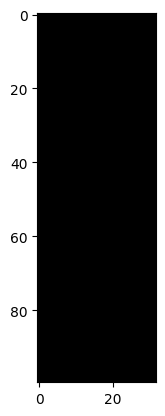

In [98]:
with torch.no_grad():
    model.eval()
    rays_o, rays_d, rays_rgb = dataset.sample_rays(max_idx = 100, ray_per_image=32)
    points = sample_points_from_rays(rays_o, rays_d, near=2.0, far=6.0, num_samples_per_ray=32, train=True)
    pred_sigmas, pred_rgbs = model(points, rays_o, rays_d)
    rend_img = volrend(pred_sigmas, pred_rgbs, 0.5)
plt.imshow(rend_img.detach().cpu().numpy()) 

In [101]:
rend_img.shape

torch.Size([100, 32, 3])

In [100]:
images_train[0].shape

(200, 200, 3)